# IRS Migration Coverage Estimates

The IRS Migration DB only includes filers who were matched between 2 consecutive years.
This notebook compares the total number of filers who filed in a year from a separate IRS report
to the number of matched filers in the database and calculates coverage rates for NYC and NY Metro

In [1]:
%matplotlib inline
import pandas as pd
import pandas.io.formats.format as pf
import sqlite3
import os
import matplotlib
matplotlib.style.use('seaborn-whitegrid')
# display numbers (floats) with thousand separator
pd.options.display.float_format = '{:,.0f}'.format

# found this hack to format integers for display with thousand separator
# https://stackoverflow.com/questions/29663252/format-pandas-integers-for-display?answertab=active#tab-top
class IntArrayFormatter(pf.GenericArrayFormatter):
    def _format_strings(self):
        formatter = self.formatter or '{:,d}'.format
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values
pf.IntArrayFormatter = IntArrayFormatter

In [2]:
#dir_path = os.getcwd()
data_path=os.path.join('source_data')
db='irs_migration_county.sqlite'
data_csv=os.path.join(data_path,'total_filers','total_filers_nycmetro.csv') # Generated from create_total_filers.py

nyc=('36005','36047','36061','36081','36085')
nyma=('34003','34013','34017','34019','34023','34025','34027','34029','34031',\
      '34035','34037','34039','36005','36047','36059','36061',\
      '36079','36081','36085','36087','36103','36119','42103')

years=['2011_12','2012_13','2013_14','2014_15','2015_16','2016_17','2017_18']

In [3]:
#Get sum of filers in the migration db for NY metro by grouping non-movers and in-migrants
con=sqlite3.connect(os.path.join (data_path, db))
df_nymetmig = pd.DataFrame()

for year in years:
    tab='inflow_{}'.format(year)
    mtotal = pd.read_sql_query('SELECT "{}" AS year, destination AS fips, \
    sum(returns) AS returns,sum(exemptions) AS exemptions \
    FROM {} where destination in {} GROUP BY destination'.format(year,tab,nyma),con)
    df_nymetmig=df_nymetmig.append(mtotal,ignore_index=True)
    
con.close()
df_nymetmig.head()

,year,fips,returns,exemptions
0,2011_12,34003,"371,057","807,049"
1,2011_12,34013,"295,175","626,910"
2,2011_12,34017,"263,118","503,759"
3,2011_12,34019,"51,835","116,546"
4,2011_12,34023,"324,297","720,522"


In [4]:
#Get total number of all filers from IRS report csv

df_totalfiler=pd.read_csv((data_csv),converters={'fips':str})
df_totalfiler.head()

,fips,cname,state,year,returns,exempts
0,34003,Bergen County,NJ,2011_12,"454,847","883,358"
1,34003,Bergen County,NJ,2012_13,"454,440","881,200"
2,34003,Bergen County,NJ,2013_14,"458,750","885,960"
3,34003,Bergen County,NJ,2014_15,"460,500","883,710"
4,34003,Bergen County,NJ,2015_16,"464,930","887,760"


In [5]:
#Join the two tables together
joined=pd.merge(df_totalfiler, df_nymetmig, on=['fips','year'])
joined.rename(columns={'returns_x':'totreturns','exempts':'totexempts',
                       'returns_y':'migreturns','exemptions':'migexempts'},inplace=True)

joined.head()

,fips,cname,state,year,totreturns,totexempts,migreturns,migexempts
0,34003,Bergen County,NJ,2011_12,"454,847","883,358","371,057","807,049"
1,34003,Bergen County,NJ,2012_13,"454,440","881,200","371,821","808,887"
2,34003,Bergen County,NJ,2013_14,"458,750","885,960","372,107","806,932"
3,34003,Bergen County,NJ,2014_15,"460,500","883,710","374,761","806,453"
4,34003,Bergen County,NJ,2015_16,"464,930","887,760","379,042","811,700"


In [6]:
#Generate summaries and calculate percentages for the NY metro area
nyma_matched=joined[['year','migreturns','totreturns','migexempts','totexempts']].groupby(['year']).sum().reset_index()
nyma_matched['pct_returns']=((nyma_matched.migreturns / nyma_matched.totreturns)*100).round(1)
nyma_matched['pct_exempts']=((nyma_matched.migexempts / nyma_matched.totexempts)*100).round(1)

nyma_matched

,year,migreturns,totreturns,migexempts,totexempts,pct_returns,pct_exempts
0,2011_12,"7,599,159","9,336,966","15,752,533","17,636,386",81,89
1,2012_13,"7,618,283","9,318,830","15,778,651","17,595,000",82,90
2,2013_14,"7,652,613","9,418,000","15,792,187","17,692,060",81,89
3,2014_15,"7,753,212","9,504,470","15,864,946","17,728,530",82,90
4,2015_16,"7,866,587","9,616,530","15,977,643","17,809,210",82,90
5,2016_17,"7,940,799","9,609,300","15,978,525","17,689,650",83,90
6,2017_18,"8,034,041","9,731,180","16,045,088","17,790,740",83,90


In [7]:
nyma_matched.iloc[:,1:5].sum()

migreturns    54,464,694
totreturns    66,535,276
migexempts   111,189,573
totexempts   123,941,576
dtype: float64

In [8]:
nyma_pct_totreturns=((nyma_matched.loc[:,'migreturns'].sum()/nyma_matched.loc[:,'totreturns'].sum())*100).round(1)
nyma_pct_totreturns

81.9

In [9]:
nyma_pct_totexempts=((nyma_matched.loc[:,'migexempts'].sum()/nyma_matched.loc[:,'totexempts'].sum())*100).round(1)
nyma_pct_totexempts

89.7

In [10]:
#Generate summaries and calculate percentages for NYC
nyc_matched=joined[joined['fips'].isin(nyc)][['year','migreturns','totreturns','migexempts','totexempts']].groupby(['year']).sum().reset_index()
nyc_matched['pct_returns']=((nyc_matched.migreturns / nyc_matched.totreturns)*100).round(1)
nyc_matched['pct_exempts']=((nyc_matched.migexempts / nyc_matched.totexempts)*100).round(1)

nyc_matched

,year,migreturns,totreturns,migexempts,totexempts,pct_returns,pct_exempts
0,2011_12,"3,263,045","3,993,358","6,345,178","7,255,391",82,88
1,2012_13,"3,272,696","3,974,160","6,370,755","7,247,540",82,88
2,2013_14,"3,297,686","4,030,410","6,402,397","7,318,410",82,88
3,2014_15,"3,364,504","4,089,180","6,485,295","7,381,290",82,88
4,2015_16,"3,425,780","4,146,860","6,553,021","7,424,620",83,88
5,2016_17,"3,452,859","4,136,210","6,536,163","7,347,810",84,89
6,2017_18,"3,498,503","4,193,810","6,565,014","7,389,230",83,89


In [11]:
nyc_matched.iloc[:,1:5].sum()

migreturns   23,575,073
totreturns   28,563,988
migexempts   45,257,823
totexempts   51,364,291
dtype: float64

In [12]:
nyc_pct_totreturns=((nyc_matched.loc[:,'migreturns'].sum()/nyc_matched.loc[:,'totreturns'].sum())*100).round(1)
nyc_pct_totreturns

82.5

In [13]:
nyc_pct_totexempts=((nyc_matched.loc[:,'migexempts'].sum()/nyc_matched.loc[:,'totexempts'].sum())*100).round(1)
nyc_pct_totexempts

88.1

In [14]:
#LaTeX example NYC table
print(nyc_matched.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} &     year &  migreturns &  totreturns &  migexempts &  totexempts &  pct\_returns &  pct\_exempts \\
\midrule
0 &  2011\_12 &   3,263,045 &   3,993,358 &   6,345,178 &   7,255,391 &           82 &           88 \\
1 &  2012\_13 &   3,272,696 &   3,974,160 &   6,370,755 &   7,247,540 &           82 &           88 \\
2 &  2013\_14 &   3,297,686 &   4,030,410 &   6,402,397 &   7,318,410 &           82 &           88 \\
3 &  2014\_15 &   3,364,504 &   4,089,180 &   6,485,295 &   7,381,290 &           82 &           88 \\
4 &  2015\_16 &   3,425,780 &   4,146,860 &   6,553,021 &   7,424,620 &           83 &           88 \\
5 &  2016\_17 &   3,452,859 &   4,136,210 &   6,536,163 &   7,347,810 &           84 &           89 \\
6 &  2017\_18 &   3,498,503 &   4,193,810 &   6,565,014 &   7,389,230 &           83 &           89 \\
\bottomrule
\end{tabular}



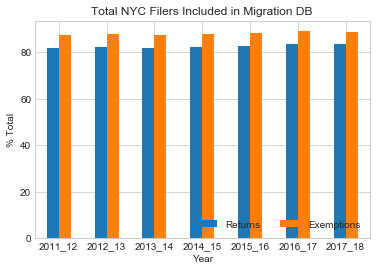

In [15]:
#Figure example NYC plot
bchart=pd.DataFrame(nyc_matched.set_index(['year']), columns=['pct_returns','pct_exempts'])
my_plot = bchart.plot(kind='bar',title="Total NYC Filers Included in Migration DB",rot=0)
my_plot.set_xlabel("Year")
my_plot.set_ylabel("% Total")
my_plot.legend(["Returns","Exemptions"], loc=4,ncol=2)

#fig = my_plot.get_figure()
#fig.savefig('test_figure.png')